In [1]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
import warnings
warnings.filterwarnings('ignore')

### Import data as train and test set

In [2]:
X_train = idx2numpy.convert_from_file('train-images-idx3-ubyte')
Y_train = idx2numpy.convert_from_file('train-labels-idx1-ubyte')

X_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
Y_test = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### Choos the first 4000 data as train_set and the rest of data as validation_set

In [4]:
X_cross = X_train[4000:]
Y_cross = Y_train[4000:]

X_train = X_train[:4000]
Y_train = Y_train[:4000]

In [5]:
X_train.shape, Y_train.shape, X_cross.shape, Y_cross.shape

((4000, 28, 28), (4000,), (56000, 28, 28), (56000,))

In [6]:
X_train_first = X_train.copy()
Y_train_first = Y_train.copy()

X_cross_first = X_cross.copy()
Y_cross_first = Y_cross.copy()

X_test_first = X_test.copy()
Y_test_first = Y_test.copy()

##### You can see THE BIG 7 in the image below

In [7]:
np.set_printoptions(linewidth=np.nan)
print(X_train[2673])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  73 248 212 160 216 254 184 161 160  87  95 108  13   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  47 230 254 254 254 254 254 254 254 254 254 254 182  12   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  32 132 150 150 150 185 245 246 250 250 254 25

#####  plt.imshow() treats 0 as brightest and 255 as darkest

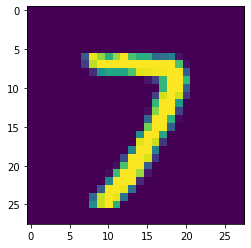

In [8]:
digit = X_train[2673]
plt.imshow(digit)
plt.show()

### Flattens X_train to 4000 * (1x28x28): Basically keeps the first dimension intact and flattens all other dimensions 

In [9]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = X_train.astype('float32')
X_train /= 255

X_cross = X_cross.reshape(X_cross.shape[0], -1)
X_cross = X_cross.astype('float32')
X_cross /= 255

X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test.astype('float32')
X_test /= 255


Y_train = np_utils.to_categorical(Y_train, 10)
Y_cross = np_utils.to_categorical(Y_cross, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

num_classes = Y_test.shape[1]

In [10]:
X_train.shape, Y_train.shape, X_cross.shape, Y_cross.shape, X_test.shape, Y_test.shape

((4000, 784), (4000, 10), (56000, 784), (56000, 10), (10000, 784), (10000, 10))

## We can either define these function for classifying the MLP problem

In [11]:
def relu(X):
    return np.maximum(X, 0)

def build_model(X , hidden_nodes , output_dim=2):
    model = {} 
    input_dim = X.shape[1]
    
    model['W1'] = np.random.randn(input_dim, hidden_nodes) / np.sqrt(input_dim)
    model['b1'] = np.zeros((1, hidden_nodes))
    model['W2'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
    model['b2'] = np.zeros((1, output_dim))
    
    return model

def feed_forward(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = relu(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    out = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return z1, a1, z2, out

def calculate_loss(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    z1, a1, z2, out = feed_forward(model, X)
    probs = out / np.sum(out, axis=1, keepdims=True)
    
    corect_logprobs = -np.log(probs[range(num_examples), y])
    loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    loss = loss + reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * loss

def relu_derivative(X):
    return 1. * (X > 0)

def backprop(X,y,model,z1,a1,z2,output,reg_lambda):
    delta3 = output
    delta3[range(X.shape[0]), y] -= 1      #yhat - y
    dW2 = (a1.T).dot(delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1) 
    dW1 = np.dot(X.T, delta2)
    db1 = np.sum(delta2, axis=0)
   
    # Add regularization terms
    dW2 = dW2 + reg_lambda * model['W2']
    dW1 = dW1 + reg_lambda * model['W1']
    return dW1, dW2, db1, db2

def train(model, X, y, num_passes=10000, reg_lambda = .1, learning_rate=0.1):
    # Batch gradient descent
    done = False
    previous_loss = float('inf')
    i = 0
    losses = []
    
    while done == False:  
        z1,a1,z2,output = feed_forward(model, X)
        dW1, dW2, db1, db2 = backprop(X,y,model,z1,a1,z2,output,reg_lambda)
        
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        
        if i % 1000 == 0:
            loss = calculate_loss(model, X, y, reg_lambda)
            losses.append(loss)
            print( "Loss after iteration %i: %f" %(i, loss)  )
            if (previous_loss-loss)/previous_loss < 0.01:
                   done = True
                    #print i
            previous_loss = loss
        i += 1
    return model, losses

## Or use the original function in sklearn.neural_network
## Relu

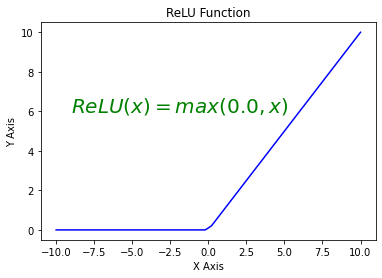

In [12]:
def ReLU(x):
    return np.maximum(0.0, x)
X = np.linspace(-10, 10, 50)
plt.plot(X, ReLU(X),'b')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('ReLU Function')
plt.text(-9, 6, r'$ReLU(x)=max(0.0, x)$', fontsize=20, color = 'g');

In [13]:
model = MLPClassifier(hidden_layer_sizes=(50,) 
                      , max_iter=150          #The 100th element represents the number of neurons in the 100th hidden layer
                      , activation='relu'     #‘relu’, the rectified linear unit function, returns f(x) = max(0, x)
                      , alpha=1e-4            #L2 penalty (regularization term) parameter
                      , solver='sgd'          #‘sgd’ refers to stochastic gradient descent.
                      , random_state=1        #random number generation for weights and bias initialization
                      , learning_rate_init=.1 #It controls the step-size in updating the weights
                      , verbose=10            #Whether to print progress messages to stdout
                      , tol=1e-4)             #Tolerance for the optimization

In [14]:
model.fit(X_train, Y_train)

Iteration 1, loss = 2.42123178
Iteration 2, loss = 0.83657275
Iteration 3, loss = 0.61264420
Iteration 4, loss = 0.51032136
Iteration 5, loss = 0.44330157
Iteration 6, loss = 0.39123516
Iteration 7, loss = 0.35202916
Iteration 8, loss = 0.31536802
Iteration 9, loss = 0.28120273
Iteration 10, loss = 0.25688425
Iteration 11, loss = 0.23137644
Iteration 12, loss = 0.20916014
Iteration 13, loss = 0.19281621
Iteration 14, loss = 0.17722671
Iteration 15, loss = 0.16124292
Iteration 16, loss = 0.14383883
Iteration 17, loss = 0.13040578
Iteration 18, loss = 0.11848535
Iteration 19, loss = 0.11050601
Iteration 20, loss = 0.09836752
Iteration 21, loss = 0.09045658
Iteration 22, loss = 0.08364164
Iteration 23, loss = 0.07662061
Iteration 24, loss = 0.07109392
Iteration 25, loss = 0.06571704
Iteration 26, loss = 0.06047811
Iteration 27, loss = 0.05612737
Iteration 28, loss = 0.05289180
Iteration 29, loss = 0.04888149
Iteration 30, loss = 0.04526143
Iteration 31, loss = 0.04281158
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=150,
              random_state=1, solver='sgd', verbose=10)

In [15]:
model.score(X_train, Y_train)

1.0

In [16]:
model.score(X_test, Y_test)

0.8717

In [17]:
def accuracy(y_pred, Y_true):
    return 100. * np.mean(y_pred == Y_true)

train_accuracy = accuracy(model.predict(X_train), Y_train)
print('Training accuracy = {:.2f}%'.format(train_accuracy))

test_accuracy = accuracy(model.predict(X_cross), Y_cross)
print('Validation accuracy = {:.2f}%'.format(test_accuracy))

test_accuracy = accuracy(model.predict(X_test), Y_test)
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 100.00%
Validation accuracy = 98.22%
Test accuracy = 98.31%


# Section with extra score
## Binary Sigmoid

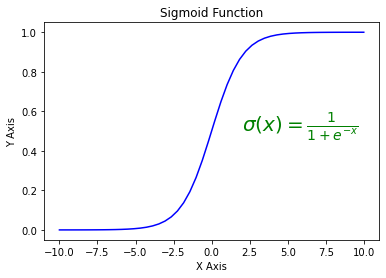

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

plt.plot(X, sigmoid(X),'b')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Sigmoid Function')
plt.text(2, 0.5, r'$\sigma(x)=\frac{1}{1+e^{-x}}$', fontsize=20 , color='g');

In [19]:
model_sigmoid = MLPClassifier(hidden_layer_sizes=(50,) 
                      , max_iter=300          #The 300th element represents the number of neurons in the 300th hidden layer
                      , activation='logistic' #‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
                      , alpha=1e-4            #L2 penalty (regularization term) parameter
                      , solver='sgd'          #‘sgd’ refers to stochastic gradient descent.
                      , random_state=1        #random number generation for weights and bias initialization
                      , learning_rate_init=.1 #It controls the step-size in updating the weights
                      , verbose=10            #Whether to print progress messages to stdout
                      , tol=1e-4)             #Tolerance for the optimization

In [20]:
model_sigmoid.fit(X_train, Y_train)

Iteration 1, loss = 3.52808891
Iteration 2, loss = 2.46808032
Iteration 3, loss = 1.66058238
Iteration 4, loss = 1.25090444
Iteration 5, loss = 1.02127205
Iteration 6, loss = 0.87591483
Iteration 7, loss = 0.77624823
Iteration 8, loss = 0.70873581
Iteration 9, loss = 0.65305051
Iteration 10, loss = 0.60940621
Iteration 11, loss = 0.57396577
Iteration 12, loss = 0.54429201
Iteration 13, loss = 0.51974749
Iteration 14, loss = 0.49870406
Iteration 15, loss = 0.47622034
Iteration 16, loss = 0.45911643
Iteration 17, loss = 0.44298295
Iteration 18, loss = 0.42696388
Iteration 19, loss = 0.41183622
Iteration 20, loss = 0.39832126
Iteration 21, loss = 0.38487805
Iteration 22, loss = 0.37356887
Iteration 23, loss = 0.36139685
Iteration 24, loss = 0.35090581
Iteration 25, loss = 0.34031751
Iteration 26, loss = 0.33230055
Iteration 27, loss = 0.32066758
Iteration 28, loss = 0.31289451
Iteration 29, loss = 0.30467253
Iteration 30, loss = 0.29643126
Iteration 31, loss = 0.28839958
Iteration 32, los

Iteration 253, loss = 0.01821899
Iteration 254, loss = 0.01810924
Iteration 255, loss = 0.01801233
Iteration 256, loss = 0.01792768
Iteration 257, loss = 0.01779706
Iteration 258, loss = 0.01771918
Iteration 259, loss = 0.01762999
Iteration 260, loss = 0.01755896
Iteration 261, loss = 0.01743077
Iteration 262, loss = 0.01734324
Iteration 263, loss = 0.01724516
Iteration 264, loss = 0.01714452
Iteration 265, loss = 0.01708443
Iteration 266, loss = 0.01697443
Iteration 267, loss = 0.01688434
Iteration 268, loss = 0.01680042
Iteration 269, loss = 0.01672904
Iteration 270, loss = 0.01663219
Iteration 271, loss = 0.01655840
Iteration 272, loss = 0.01648061
Iteration 273, loss = 0.01637624
Iteration 274, loss = 0.01631973
Iteration 275, loss = 0.01623125
Iteration 276, loss = 0.01614169
Iteration 277, loss = 0.01607253
Iteration 278, loss = 0.01598877
Iteration 279, loss = 0.01589138
Iteration 280, loss = 0.01581532
Iteration 281, loss = 0.01575122
Iteration 282, loss = 0.01567608
Iteration 

MLPClassifier(activation='logistic', hidden_layer_sizes=(50,),
              learning_rate_init=0.1, max_iter=300, random_state=1,
              solver='sgd', verbose=10)

In [21]:
model_sigmoid.score(X_train, Y_train)

0.99975

In [22]:
model_sigmoid.score(X_test, Y_test)

0.8833

In [23]:
def accuracy(y_pred, Y_true):
    return 100. * np.mean(y_pred == Y_true)

train_accuracy = accuracy(model_sigmoid.predict(X_train), Y_train)
print('Training accuracy = {:.2f}%'.format(train_accuracy))

validation_accuracy = accuracy(model_sigmoid.predict(X_cross), Y_cross)
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

test_accuracy = accuracy(model_sigmoid.predict(X_test), Y_test)
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 100.00%
Validation accuracy = 98.36%
Test accuracy = 98.42%


## Bipolar sigmoid

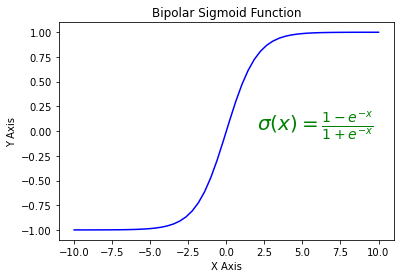

In [24]:
def bipolar_sigmoid(x):
    return (1 - np.exp(-x)) / (1 + np.exp(-x))

plt.plot(X, bipolar_sigmoid(X),'b')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Bipolar Sigmoid Function')
plt.text(2, 0, r'$\sigma(x)=\frac{1-e^{-x}}{1+e^{-x}}$', fontsize=20 , color='g');

In [25]:
@np.vectorize
def bipolar_sigmoid(x):
    return 1 - np.exp(-x) / (1 + np.exp(-x))
activation_function = bipolar_sigmoid

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_bipolar_sigmoid:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))
        
    
    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """
        
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)
        

        
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
            
    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    
    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
        
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [26]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid = NeuralNetwork_bipolar_sigmoid(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)

In [27]:
for i in range(len(X_train_first)):
    model_bipolar_sigmoid.train(X_train[i], Y_train[i])

for i in range(20):
    res = model_bipolar_sigmoid.run(X_test[i])
    print(Y_test_first[i], np.argmax(res), np.max(res))

7 7 0.9817717601345887
2 2 0.8197694228263859
1 1 0.9511151912077453
0 0 0.8650805771796739
4 4 0.8130866134507392
1 1 0.9650359159623102
4 4 0.7896967071902083
9 9 0.9346823780599279
5 6 0.21617861527832338
9 9 0.9507453017416608
0 0 0.9027836637533105
6 6 0.15767906348487348
9 9 0.9507242691299035
0 0 0.9326332226171831
1 1 0.9615935178827897
5 5 0.3645434814711983
9 9 0.8601144691124029
7 7 0.9863732831527621
3 6 0.11843036117907835
4 4 0.9212052308643537


In [28]:
corrects, wrongs = model_bipolar_sigmoid.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 90.00%
Validation accuracy = 86.64%
Test accuracy = 87.72%


## Binary Sigmoid for varying slope parameter k

In [29]:
List = [1,1.5,2,3,5,10]
for i in List:
    def sigmoid_epoch(x, i):
        return 1 / (1 + np.exp(-i * x))

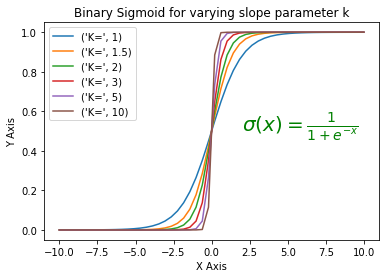

In [30]:
for i in List:
    plt.plot(X, sigmoid_epoch(X, i), label = ('K=', i))
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.legend()
plt.title('Binary Sigmoid for varying slope parameter k')
plt.text(2, 0.5, r'$\sigma(x)=\frac{1}{1+e^{-x}}$', fontsize=20 , color='g');

# K = 1

In [31]:
@np.vectorize
def sigmoid_epoch(x, k=1):
    return 1 / (1 + np.exp(-k * x))
activation_function = sigmoid_epoch

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_k1:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))


    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """

        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)




    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()


    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs


In [32]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid_k1 = NeuralNetwork_k1(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
for j in range(len(X_train_first)):
    model_bipolar_sigmoid_k1.train(X_train[j], Y_train[j])

for k in range(20):
    res = model_bipolar_sigmoid_k1.run(X_test[k])
    print(Y_test_first[k], np.argmax(res), np.max(res))

7 7 0.9773583313100611
2 2 0.7664072390209746
1 1 0.9479124584778028
0 0 0.9009908303564983
4 4 0.8353478267656799
1 1 0.9625650300404567
4 4 0.7309195873749819
9 9 0.9449424303694307
5 6 0.24402226585176812
9 9 0.9436290040449626
0 0 0.873363237689474
6 2 0.12300896500010892
9 9 0.9362913329589184
0 0 0.9391326250872991
1 1 0.9592621524892833
5 5 0.49884881791429264
9 9 0.8593537138126668
7 7 0.9835117972930619
3 6 0.13562253690709372
4 4 0.9154642554557619


In [33]:
corrects, wrongs = model_bipolar_sigmoid_k1.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k1.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k1.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 89.60%
Validation accuracy = 86.70%
Test accuracy = 87.69%


# K = 5

In [34]:
@np.vectorize
def sigmoid_epoch(x, k=5):
    return 1 / (1 + np.exp(-k * x))
activation_function = sigmoid_epoch

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_k5:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))


    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """

        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)




    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()


    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs


In [35]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid_k5 = NeuralNetwork_k5(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
for j in range(len(X_train_first)):
    model_bipolar_sigmoid_k5.train(X_train[j], Y_train[j])

for k in range(20):
    res = model_bipolar_sigmoid_k5.run(X_test[k])
    print(Y_test_first[k], np.argmax(res), np.max(res))

7 7 0.9997617738256998
2 2 0.6196689531197387
1 1 0.9953684032369083
0 0 0.9951586798550511
4 4 0.7126217178023606
1 1 0.9972003758834939
4 4 0.6045316813357866
9 9 0.9932365867844513
5 2 0.19369050215713907
9 9 0.9996742171850658
0 0 0.9661980204837681
6 6 0.1389339557490096
9 9 0.9975365529774355
0 0 0.9887852614285244
1 1 0.9941306558225763
5 5 0.9271066916337988
9 9 0.9878475942306151
7 7 0.9999305934420616
3 6 0.18754677899646502
4 4 0.9875187814813488


In [36]:
corrects, wrongs = model_bipolar_sigmoid_k5.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k5.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k5.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 91.92%
Validation accuracy = 88.40%
Test accuracy = 89.43%


# K = 10

In [37]:
@np.vectorize
def sigmoid_epoch(x, k=10):
    return 1 / (1 + np.exp(-k * x))
activation_function = sigmoid_epoch

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_k10:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))


    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """

        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)




    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()


    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs


In [38]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid_k10 = NeuralNetwork_k10(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
for j in range(len(X_train_first)):
    model_bipolar_sigmoid_k10.train(X_train[j], Y_train[j])

for k in range(20):
    res = model_bipolar_sigmoid_k10.run(X_test[k])
    print(Y_test_first[k], np.argmax(res), np.max(res))

7 7 0.9999872822502559
2 2 0.9754059161331644
1 1 0.9985690338706708
0 0 0.9904079750038478
4 4 0.9272253585375546
1 1 0.997697250132368
4 4 0.9459552065211029
9 9 0.9881372861989332
5 6 0.13963464332384865
9 9 0.9999157315247659
0 0 0.9849045670618253
6 6 0.06473618362050854
9 9 0.9998341203661174
0 0 0.9948904481866636
1 1 0.997217887175221
5 5 0.9461113429149751
9 9 0.9995563107843616
7 7 0.999979069935058
3 3 0.04605882620169942
4 4 0.9997725786382979


In [39]:
corrects, wrongs = model_bipolar_sigmoid_k10.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k10.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k10.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 91.77%
Validation accuracy = 87.41%
Test accuracy = 88.12%


# K = 20

In [40]:
@np.vectorize
def sigmoid_epoch(x, k=20):
    return 1 / (1 + np.exp(-k * x))
activation_function = sigmoid_epoch

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_k20:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))


    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """

        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)




    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()


    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs


In [41]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid_k20 = NeuralNetwork_k20(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
for j in range(len(X_train_first)):
    model_bipolar_sigmoid_k20.train(X_train[j], Y_train[j])

for k in range(20):
    res = model_bipolar_sigmoid_k20.run(X_test[k])
    print(Y_test_first[k], np.argmax(res), np.max(res))

7 7 0.9999990292612972
2 2 0.9995514344952132
1 1 0.9999624037805988
0 0 0.9962223356255047
4 4 0.999674240298706
1 1 0.9998350912017191
4 4 0.9966448968589988
9 9 0.97507607886701
5 2 0.031072986367365173
9 9 0.9981051430070458
0 0 0.991700593739728
6 6 0.6200074520111968
9 9 0.9900256429000448
0 0 0.9963341493330846
1 1 0.9999247533333129
5 5 0.5022804947722941
9 9 0.9988812794627785
7 7 0.9999999870865346
3 8 0.28767702388948974
4 4 0.9999986388874612


In [42]:
corrects, wrongs = model_bipolar_sigmoid_k20.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k20.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k20.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 90.80%
Validation accuracy = 86.59%
Test accuracy = 87.33%


# K = 30

In [43]:
@np.vectorize
def sigmoid_epoch(x, k=30):
    return 1 / (1 + np.exp(-k * x))
activation_function = sigmoid_epoch

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_k30:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))


    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """

        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)




    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()


    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs


In [44]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid_k30 = NeuralNetwork_k30(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
for j in range(len(X_train_first)):
    model_bipolar_sigmoid_k30.train(X_train[j], Y_train[j])

for k in range(20):
    res = model_bipolar_sigmoid_k30.run(X_test[k])
    print(Y_test_first[k], np.argmax(res), np.max(res))

7 7 0.9999999999228335
2 2 0.22557498968465203
1 1 0.9999999773562253
0 0 0.9764805717466953
4 4 0.9987946258995195
1 1 0.9999954186914669
4 4 0.9956491246864926
9 9 0.9996100324057023
5 6 0.9424083567474749
9 9 0.9999860107074721
0 0 0.9999945854758288
6 2 0.002636577085478741
9 9 0.9999970613931065
0 0 0.9999382630469994
1 1 0.9999795049059715
5 5 0.6369972129095626
9 9 0.9999984564552287
7 7 0.9999999999998122
3 9 0.019950019558818078
4 4 0.9999764823034104


In [45]:
corrects, wrongs = model_bipolar_sigmoid_k30.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k30.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k30.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 87.75%
Validation accuracy = 84.18%
Test accuracy = 85.04%


# K = 40

In [46]:
@np.vectorize
def sigmoid_epoch(x, k=40):
    return 1 / (1 + np.exp(-k * x))
activation_function = sigmoid_epoch

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_k40:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))


    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """

        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)




    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()


    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs


In [47]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid_k40 = NeuralNetwork_k40(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
for j in range(len(X_train_first)):
    model_bipolar_sigmoid_k40.train(X_train[j], Y_train[j])

for k in range(20):
    res = model_bipolar_sigmoid_k40.run(X_test[k])
    print(Y_test_first[k], np.argmax(res), np.max(res))

7 7 0.9999999981748608
2 3 0.9905718767635542
1 1 0.998662092805932
0 0 0.9999999900390101
4 4 0.7314849525860865
1 1 0.9996676431751202
4 4 0.9919718086840591
9 5 0.1364674626508543
5 4 0.933455964290478
9 9 0.9988913652653826
0 0 0.99999578348661
6 0 0.28705044502824795
9 9 0.941837893582741
0 0 0.9999997541326957
1 1 0.9995738640278848
5 0 0.008132346543078721
9 9 0.999733244875696
7 7 0.9999996800417577
3 8 0.6489798799335852
4 4 0.9999957746566942


In [48]:
corrects, wrongs = model_bipolar_sigmoid_k40.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k40.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k40.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 86.72%
Validation accuracy = 82.74%
Test accuracy = 82.68%


# K = 50

In [49]:
@np.vectorize
def sigmoid_epoch(x, k=50):
    return 1 / (1 + np.exp(-k * x))
activation_function = sigmoid_epoch

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_k50:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))


    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """

        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)




    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()


    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs


In [50]:
image_size = 28
image_pixels = image_size * image_size
model_bipolar_sigmoid_k50 = NeuralNetwork_k50(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
for j in range(len(X_train_first)):
    model_bipolar_sigmoid_k50.train(X_train[j], Y_train[j])

for k in range(20):
    res = model_bipolar_sigmoid_k50.run(X_test[k])
    print(Y_test_first[k], np.argmax(res), np.max(res))

7 7 0.9999999999992675
2 2 0.6663015173837696
1 1 0.9999999987785579
0 0 0.9999871490493888
4 4 0.9879727098869728
1 1 0.9999999962060284
4 4 0.9999987019106925
9 9 0.9999999999517433
5 6 0.9620129544712079
9 9 0.9999999991190602
0 0 0.999997375490745
6 2 0.11068331625178275
9 9 0.9997314612096624
0 0 0.9999988977749613
1 1 0.9999997239147392
5 8 0.03366735313174564
9 9 0.9999995096882305
7 7 0.9999999981667502
3 2 0.6339372752119377
4 4 0.9999997503632351


In [51]:
corrects, wrongs = model_bipolar_sigmoid_k50.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k50.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_bipolar_sigmoid_k50.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 84.10%
Validation accuracy = 81.37%
Test accuracy = 81.37%


# Binary sigmoid in desire interval
#### We can multiply / divide the formula by a number or add / subtract with a number. 
# Multiply

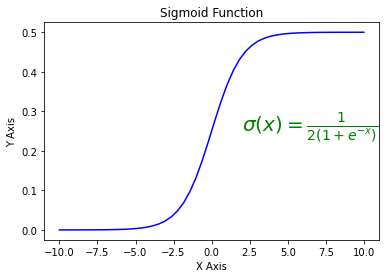

In [52]:
def sigmoid_2(x):
    return (1 / (1 + np.exp(-x))) / 2

plt.plot(X, sigmoid_2(X),'b')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Sigmoid Function')
plt.text(2, 0.25, r'$\sigma(x)=\frac{1}{2(1+e^{-x})}$', fontsize=20 , color='g');

In [53]:
@np.vectorize
def sigmoid_2(x):
    return (1 / (1 + np.exp(-x))) / 7
activation_function = sigmoid_2

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork_s2:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))
        
    
    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """
        
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)
        

        
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
            
    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    
    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
        
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [54]:
image_size = 28
image_pixels = image_size * image_size
model_sigmoid_interval_2 = NeuralNetwork_s2(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)

In [55]:
for i in range(len(X_train_first)):
    model_sigmoid_interval_2.train(X_train[i], Y_train[i])

for i in range(20):
    res = model_sigmoid_interval_2.run(X_test[i])
    print(Y_test_first[i], np.argmax(res), np.max(res))

7 7 0.10357929900380532
2 1 0.10413927343419496
1 1 0.11072379785618609
0 1 0.10137784501252654
4 4 0.10450212884328293
1 1 0.1096040798463119
4 4 0.1013981217211807
9 1 0.10578930495540681
5 1 0.10627360800228376
9 1 0.1058698600791738
0 0 0.10114060200808159
6 1 0.10626664079847918
9 4 0.1030349809944178
0 0 0.09929565114251092
1 1 0.10765303313302946
5 1 0.10216535748179165
9 4 0.1039471446301129
7 7 0.10202995231784882
3 1 0.10633179745631394
4 4 0.10355992956106612


In [56]:
corrects, wrongs = model_sigmoid_interval_2.evaluate(X_train, Y_train_first)
train_accuracy = (corrects / ( corrects + wrongs))*100
print("Training accuracy = {:.2f}%".format(train_accuracy))

corrects, wrongs = model_sigmoid_interval_2.evaluate(X_cross, Y_cross_first)
validation_accuracy = (corrects / ( corrects + wrongs))*100
print('Validation accuracy = {:.2f}%'.format(validation_accuracy))

corrects, wrongs = model_sigmoid_interval_2.evaluate(X_test, Y_test_first)
test_accuracy = (corrects / ( corrects + wrongs))*100
print('Test accuracy = {:.2f}%'.format(test_accuracy))

Training accuracy = 25.02%
Validation accuracy = 24.16%
Test accuracy = 24.46%


### Extra work for visualizing the results much more better

In [57]:
model = Sequential()

# First Hidden Layer
model.add( Dense(units=100, input_shape=(28*28,), activation='relu',name='Hidden-1'))
# Second Hidden Layer
model.add( Dense(units=100, activation='relu',name='Hidden-2') )
# Output layer
model.add( Dense(units=num_classes, activation='sigmoid',name='OutputLayer') )
#sgd stands for : stochastic gradient descent
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden-1 (Dense)             (None, 100)               78500     
_________________________________________________________________
Hidden-2 (Dense)             (None, 100)               10100     
_________________________________________________________________
OutputLayer (Dense)          (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(X_train, Y_train, validation_data=(X_cross, Y_cross), epochs=20, batch_size=200, verbose=1)
print(history.history.keys())

Epoch 1/20
20/20 [==============================] - 2s 81ms/step - loss: 2.3401 - acc: 0.1043 - val_loss: 2.2446 - val_acc: 0.1583
Epoch 2/20
20/20 [==============================] - 0s 22ms/step - loss: 2.2310 - acc: 0.1828 - val_loss: 2.1528 - val_acc: 0.3019
Epoch 3/20
20/20 [==============================] - 0s 22ms/step - loss: 2.1263 - acc: 0.3402 - val_loss: 2.0602 - val_acc: 0.4168
Epoch 4/20
20/20 [==============================] - 0s 22ms/step - loss: 2.0297 - acc: 0.4518 - val_loss: 1.9640 - val_acc: 0.4832
Epoch 5/20
20/20 [==============================] - 0s 24ms/step - loss: 1.9343 - acc: 0.5051 - val_loss: 1.8637 - val_acc: 0.5391
Epoch 6/20
20/20 [==============================] - 0s 25ms/step - loss: 1.8291 - acc: 0.5646 - val_loss: 1.7599 - val_acc: 0.5890
Epoch 7/20
20/20 [==============================] - 0s 24ms/step - loss: 1.7255 - acc: 0.6131 - val_loss: 1.6528 - val_acc: 0.6343
Epoch 8/20
20/20 [==============================] - 1s 27ms/step - loss: 1.6050 - a

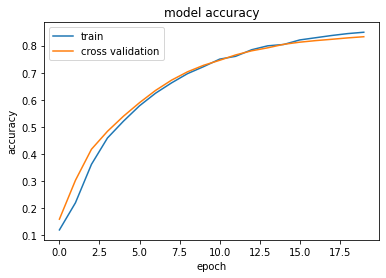

In [59]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cross validation'], loc='upper left')
plt.show()

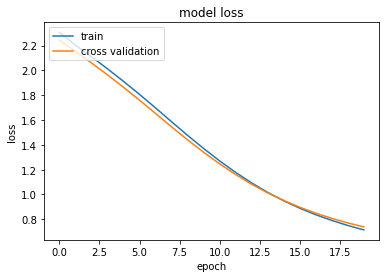

In [60]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cross validation'], loc='upper left')
plt.show()

In [61]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.8410999774932861


In [62]:
Y_pred = model.predict_classes(X_test,verbose=1)
Y_test = np.argmax(Y_test, axis=1) 

313/313 [==============================] - 0s 1ms/step


In [63]:
correct_indices = list(np.where(Y_pred == Y_test)[0])
incorrect_indices = list(np.where(Y_pred != Y_test)[0])

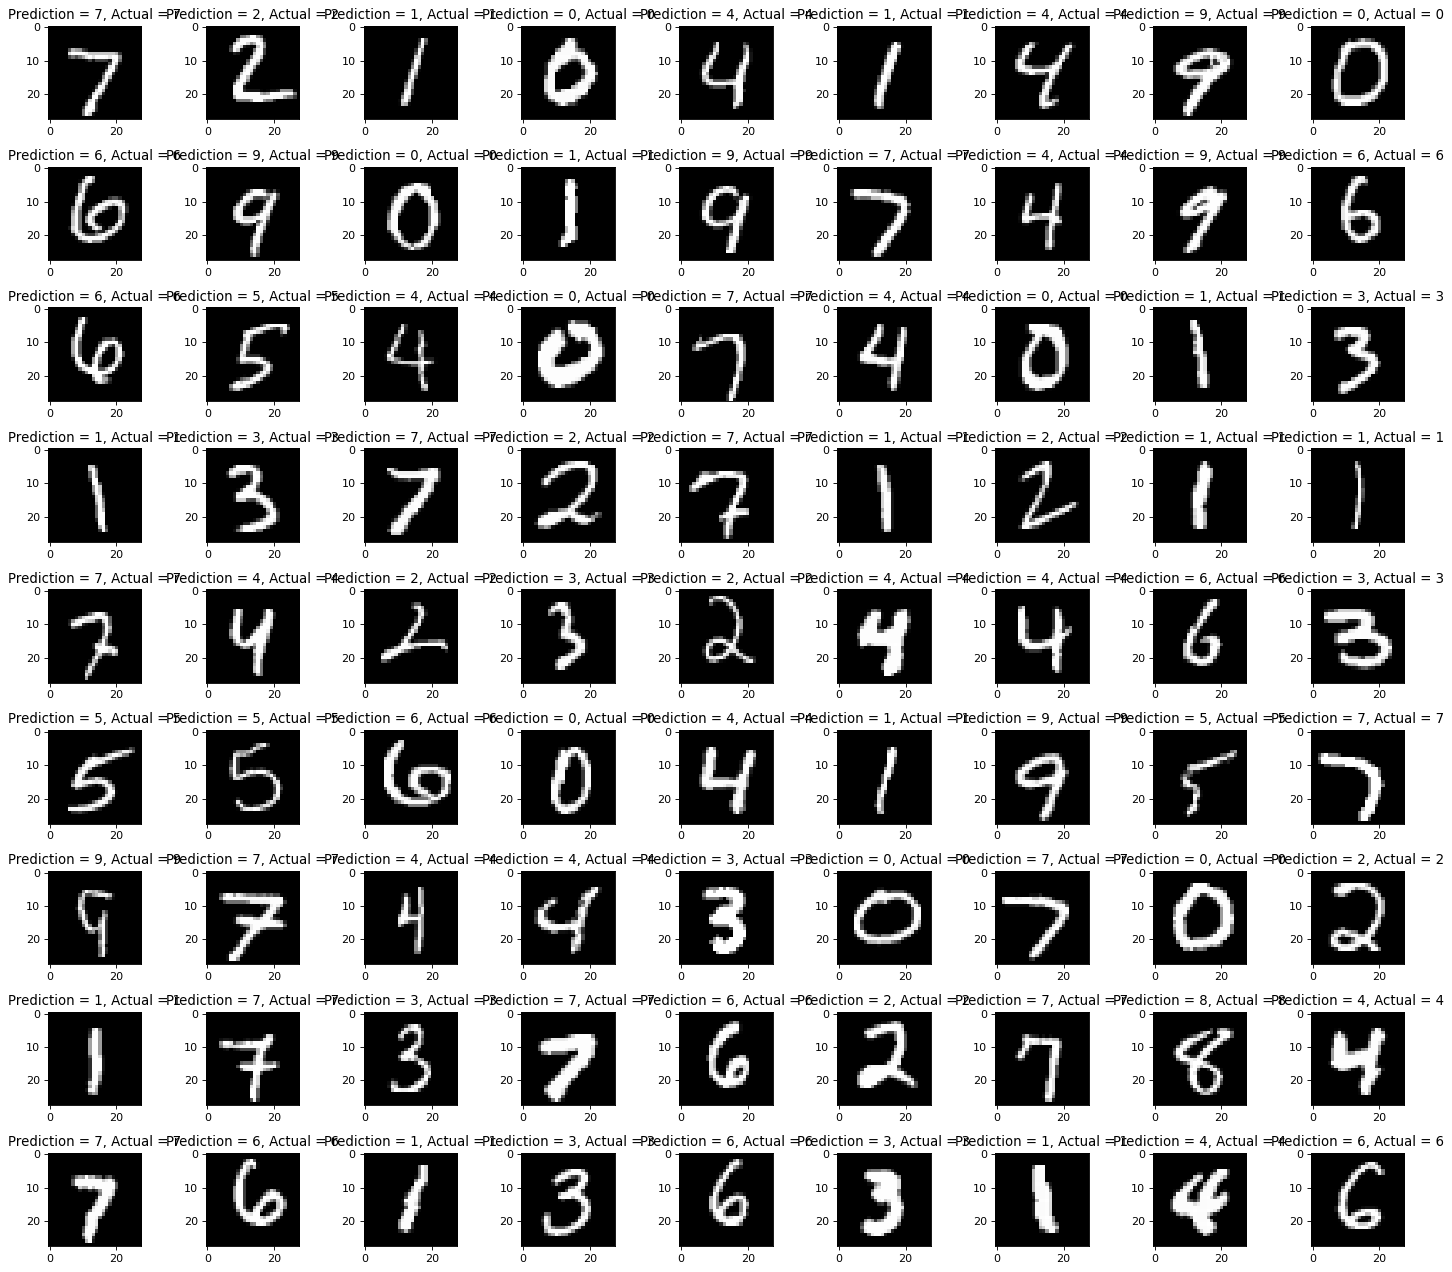

In [64]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

for i, correct in enumerate(correct_indices[:81]):
    plt.subplot(9,9,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Prediction = {}, Actual = {}".format(Y_pred[correct], Y_test[correct]))   

plt.tight_layout()

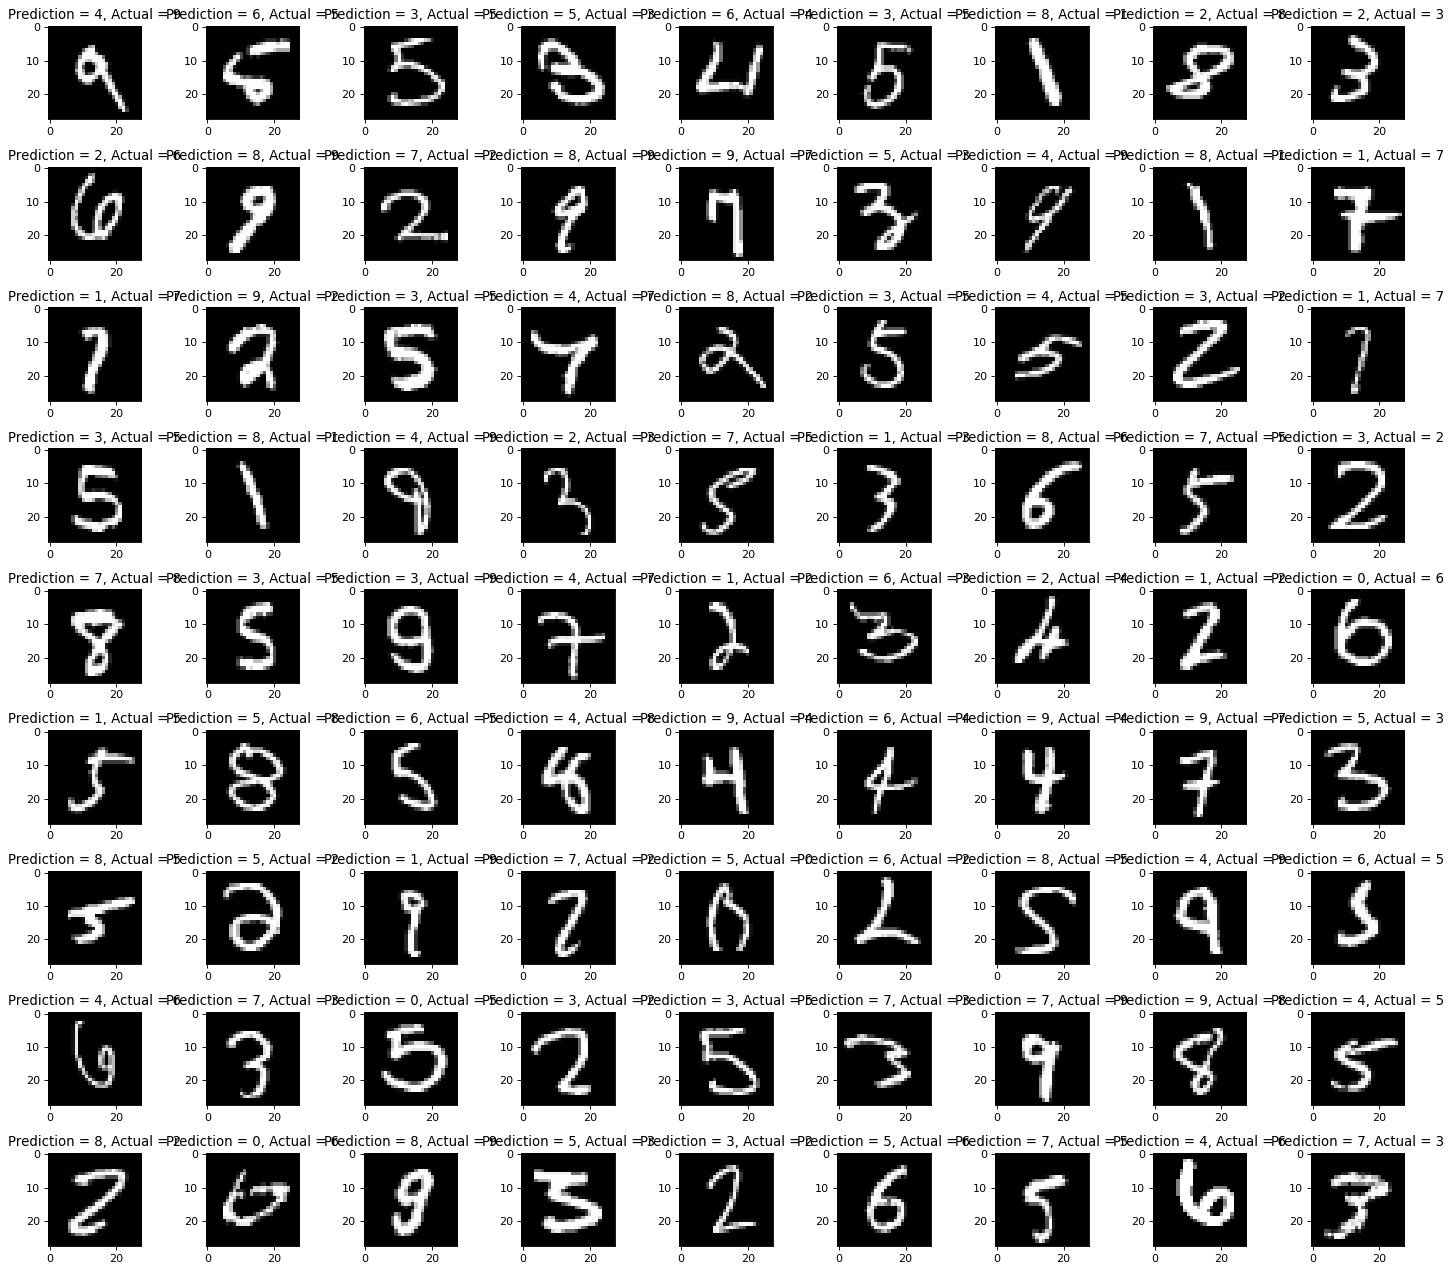

In [65]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

for i, incorrect in enumerate(incorrect_indices[:81]):
    plt.subplot(9,9,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Prediction = {}, Actual = {}".format(Y_pred[incorrect], Y_test[incorrect]))   

plt.tight_layout()